# Removing MR-related artifact and cleaning physiological data
Acquired during either a single-echo, simultaneous multislice EPI scan or a multi-echo, simultaneous multislice EPI scan collected while participants performed tasks and watched movies in a 3T Siemens PRISMA scanner.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bioread as br
from matplotlib.ticker import FormatStrFormatter


from glob import glob
import scipy.signal as signal
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances, pairwise_distances_chunked
#from tslearn.metrics import dtw

In [1]:
import scipy
print('SciPy version', scipy.__version__)

import numpy
print('Numpy version', numpy.__version__)

import pandas
print('Pandas version', pandas.__version__)

import bioread
print('bioread version', bioread.__version__)

import sys 
print("Python version", sys.version) 

SciPy version 1.5.1
Numpy version 1.19.0
Pandas version 1.0.5
bioread version 1.0.4
Python version 3.7.8 (v3.7.8:4b47a5b6ba, Jun 27 2020, 04:47:50) 
[Clang 6.0 (clang-600.0.57)]


Creating color palette...

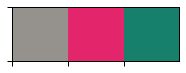

In [2]:
sns.set_context('paper', font_scale=3)

pal = sns.crayon_palette(['Gray', 'Razzmatazz', 'Tropical Rain Forest'])
sns.set_palette(pal)
sns.palplot(pal)

## Here, we use `scipy.signal` functions to assemble various digital filters

In [3]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

# Electrocardiogram data
## Single-band, single-echo EPI sequence

In [5]:
data_fname = '/Users/kbottenh/Dropbox/Projects/physio/mbme-physio-denoising/example_data/4232_2_Musser_K23_redux.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/kbottenh/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [6]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Digital' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel

In [7]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [8]:
#from Erica Musser's K23 EIRT sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = data.samples_per_second

nyquist = fs/2
Q = 100

### Fourier transform of ECG recording in absence of MR sequence

In [9]:
fft_ecg = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

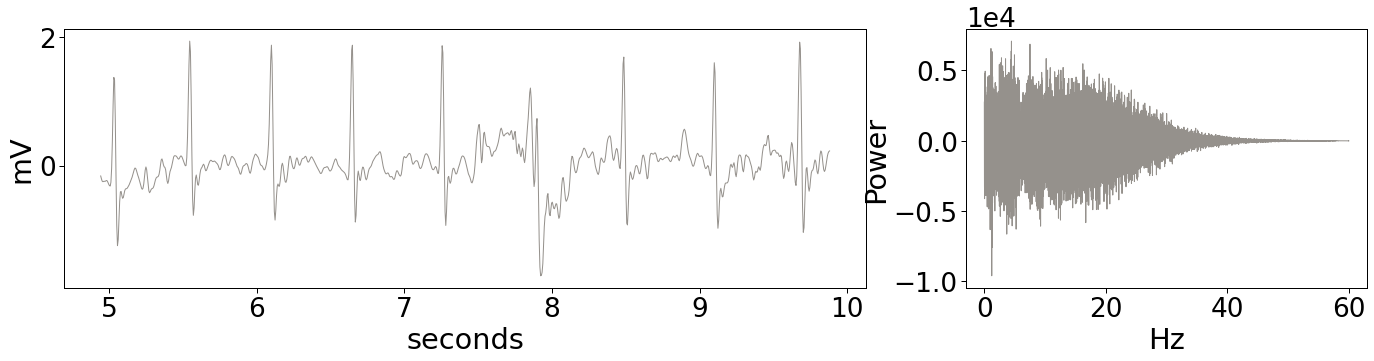

In [10]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:2000], 
             signal.decimate(timeseries['ECG'][:200000], 10)[1000:2000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_ecg.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-ecg_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [11]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(i, np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 5.5885, 1: 5.595258333333334, 2: 5.592233333333334, 3: 5.563108333333333, 4: 5.001758333333333, 5: 5.001774999999999}


In [12]:
scan1 = timeseries[timeseries.index.isin(scan_idx[1])]
time = scan1['seconds'].values

In [13]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=data.samples_per_second)

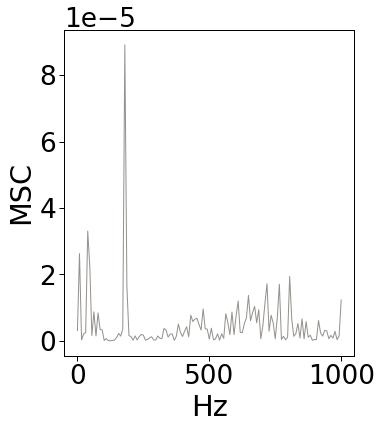

In [14]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgRaw.png'.format(out_dir, basename, i), dpi=300)

In [15]:
fft_ecg = np.fft.fft(scan1['ECG'].values)
freq = np.fft.fftfreq(scan1['ECG'].values.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)

In [16]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

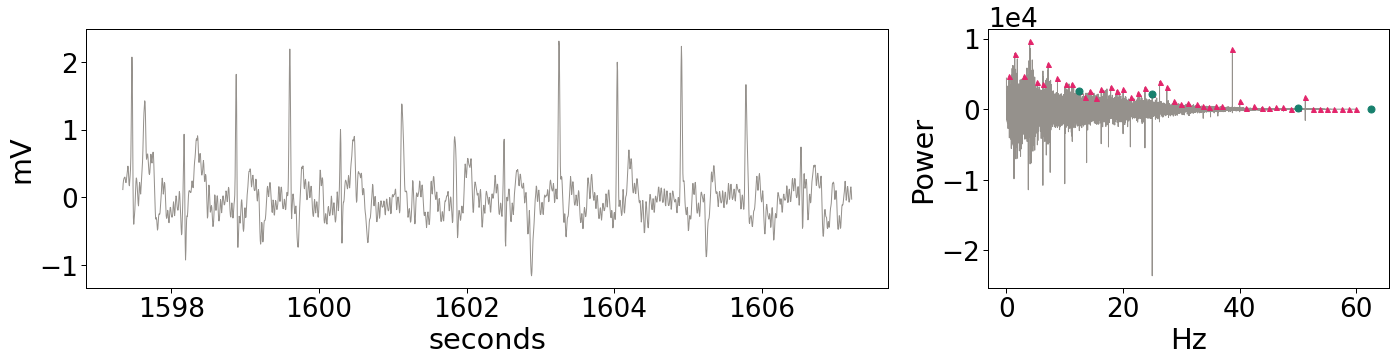

In [17]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(scan1['ECG'], 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_ecg.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:50], fft_ecg.real[peaks][:50], "^", ms=5)
ax2.plot(freq[slice_peaks][:4], fft_ecg.real[slice_peaks][:4], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_ecg-raw.png'.format(out_dir, basename, i), dpi=300)

In [18]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / tr
filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)
f, Cxy = signal.coherence(scan1['ECG'], filtered, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

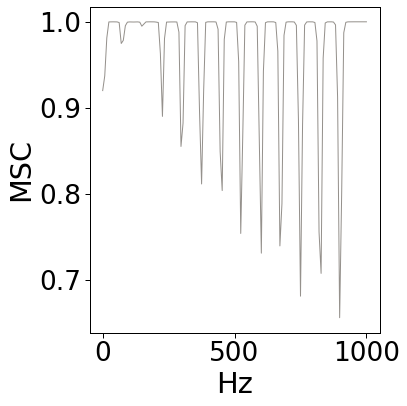

In [19]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300)

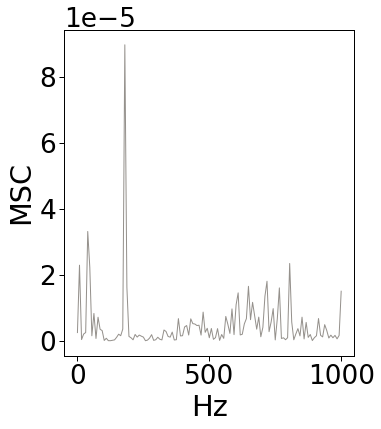

In [20]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], filtered, fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300)

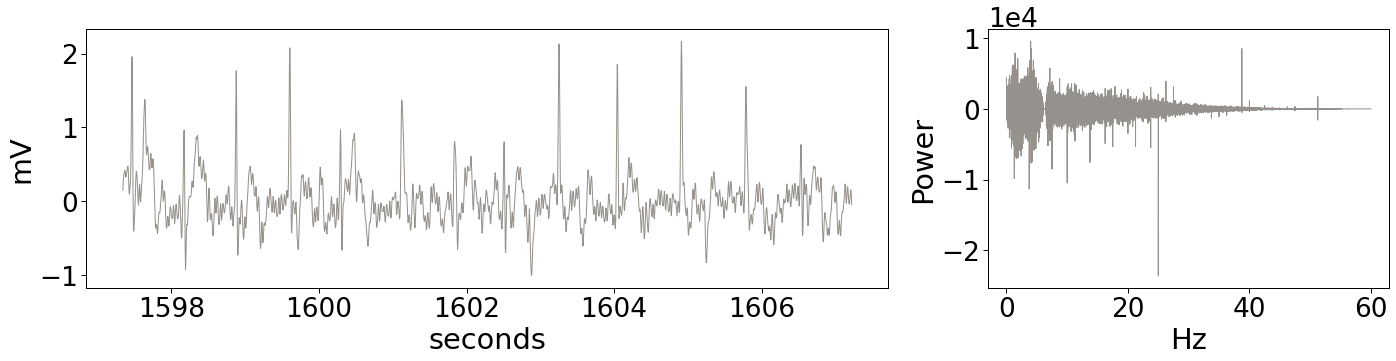

In [21]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [22]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / mb / tr
filtered1 = comb_band_stop(notch, scan1['ECG'], Q, fs)
f, Cxy = signal.coherence(scan1['ECG'], filtered1, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

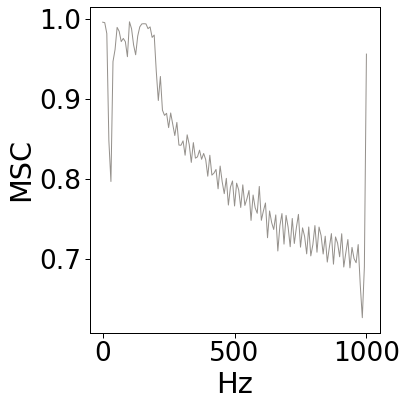

In [23]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

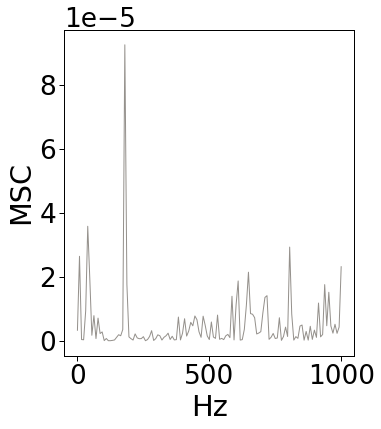

In [24]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], filtered1, fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

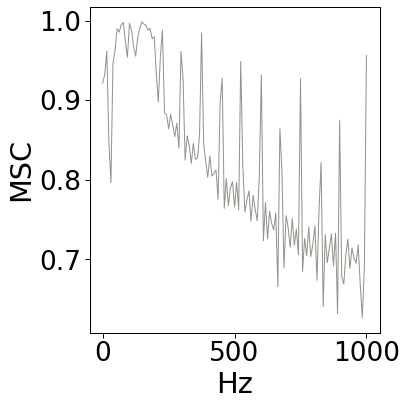

In [25]:
f, Cxy = signal.coherence(filtered, filtered1, fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgBioPacCleanXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

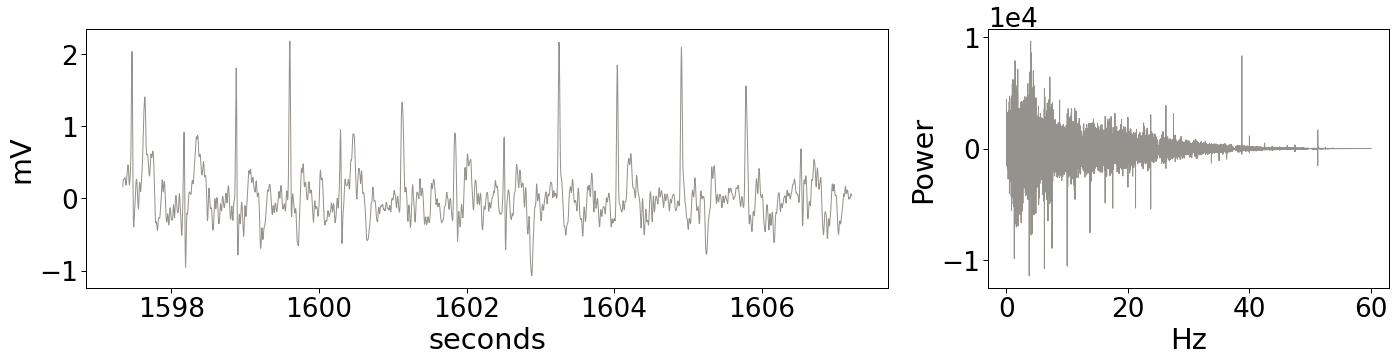

In [26]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered1, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

## Multiband, multi-echo EPI sequence

In [27]:
data_fname = '/Users/kbottenh/Dropbox/Projects/physio/mbme-physio-denoising/example_data/sub-Blossom_ses-01.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/kbottenh/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [28]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Trigger' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel


In [29]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [30]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = data.samples_per_second

#I don't know if this is right, been playing around with the value of Q
Q = 100

nyquist = fs/2

In [31]:
fft_ecg = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

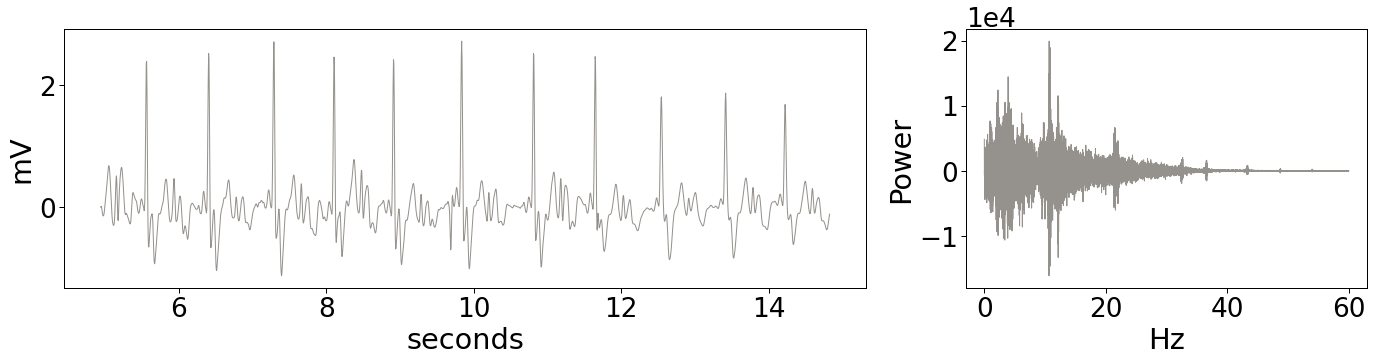

In [32]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:3000], 
             signal.decimate(timeseries['ECG'][:200000], 10)[1000:3000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_ecg.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-ecg_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [33]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 9.394791666666666, 1: 7.744491666666667, 2: 7.7928, 3: 7.350816666666666, 4: 7.976075, 5: 10.925783333333333, 6: 7.412583333333333, 7: 7.43005, 8: 5.836325, 9: 8.253416666666666, 10: 5.0017249999999995, 11: 5.001608333333333}


In [34]:
scan1 = timeseries[timeseries.index.isin(scan_idx[0])]
time = scan1['seconds'].values

In [35]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=data.samples_per_second)

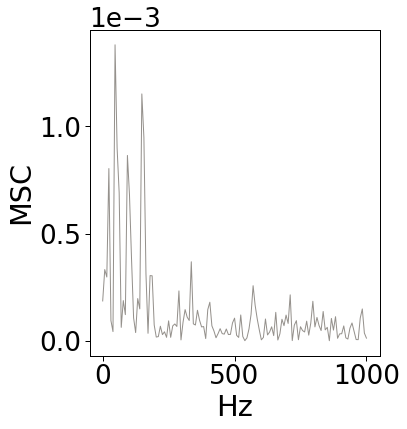

In [36]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgRaw.png'.format(out_dir, basename, i), dpi=300)

In [37]:
fft_ecg = np.fft.fft(scan1['ECG'].values)
freq = np.fft.fftfreq(scan1['ECG'].values.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=150)

In [38]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

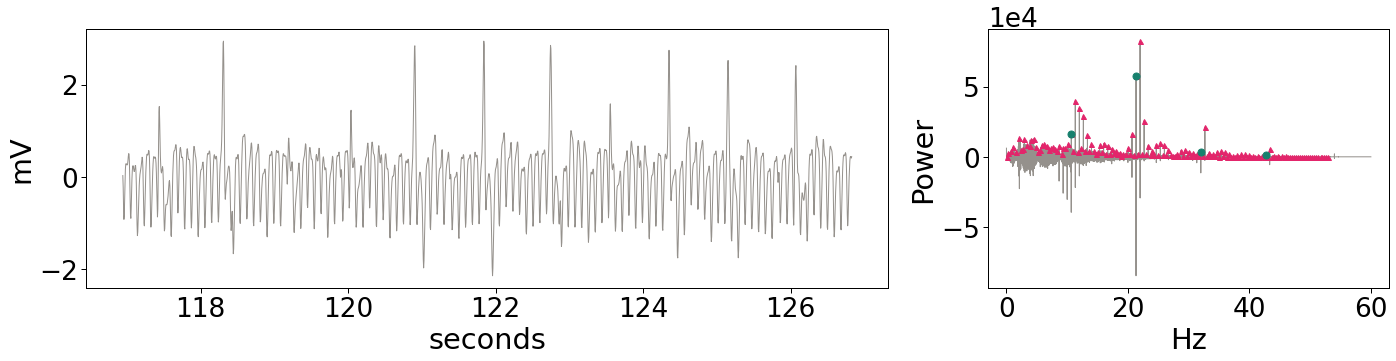

In [39]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(scan1['ECG'], 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_ecg.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:220], fft_ecg.real[peaks][:220], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_ecg.real[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_ecg-raw.png'.format(out_dir, basename, i), dpi=300)

### Filtering with BioPac recommendations
Note 242 suggests filtering slices/TR

In [40]:
notch = slices / tr
filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)
f, Cxy = signal.coherence(scan1['ECG'], filtered, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

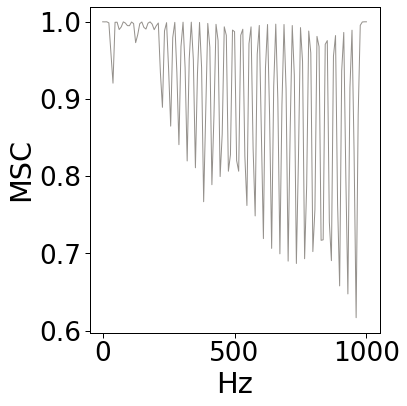

In [41]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300)

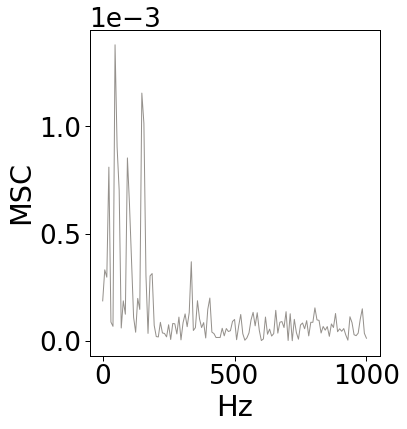

In [42]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered, 
                          fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300)

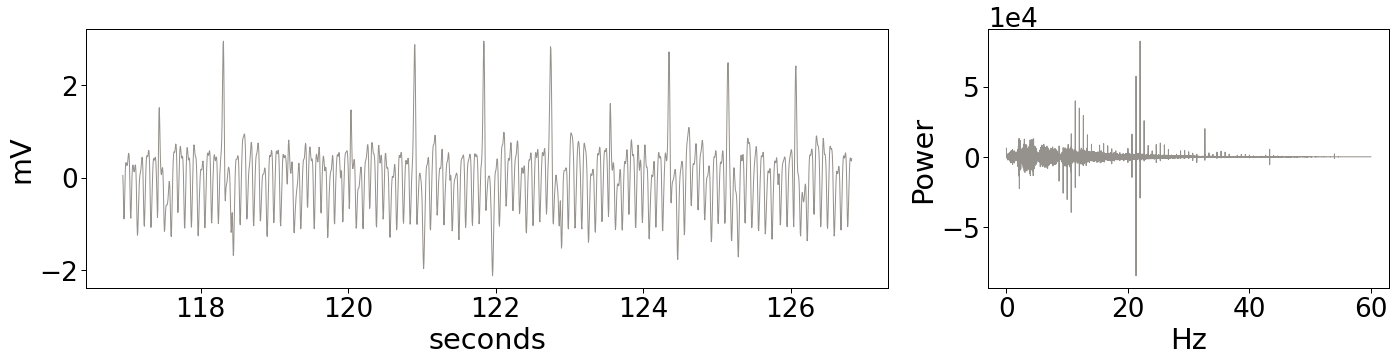

In [43]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

### Filtering with the Bottenhorn Recommendations

In [44]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}

#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
filtered1 = scan1['ECG']
for notch in notches:
    filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

fft_filt1 = np.fft.fft(filtered1)
freq1 = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt1))
limit = np.where(freq1 >= 60)[0][0]

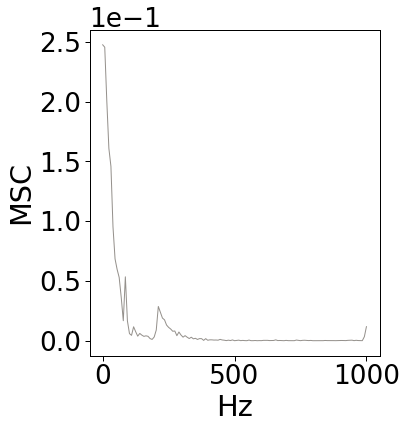

In [45]:
f, Cxy = signal.coherence(scan1['ECG'], filtered1, fs=data.samples_per_second)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

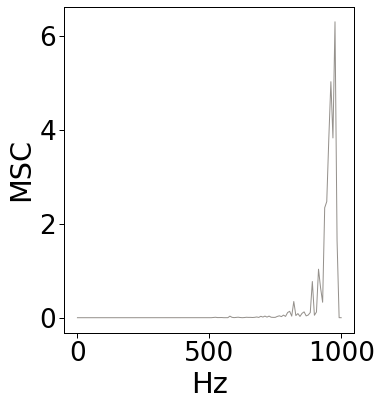

In [46]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered1, 
                          fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

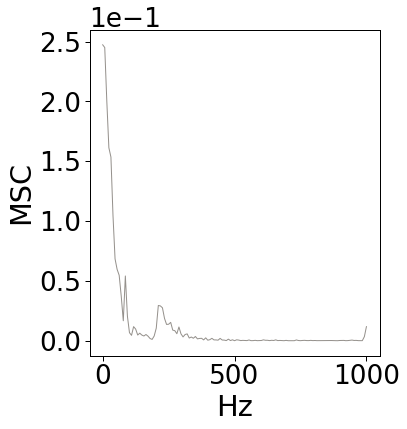

In [47]:
f, Cxy = signal.coherence(filtered, 
                          filtered1, 
                          fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgBioPacCleanXecgBottenClean.png'.format(out_dir, basename, i), dpi=300)

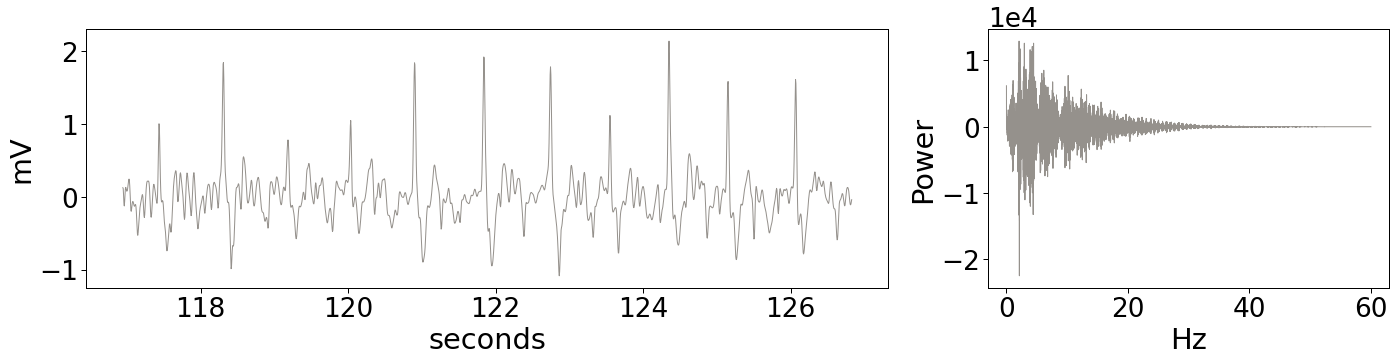

In [48]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered1, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq1[:limit], fft_filt1.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BottenClean.png'.format(out_dir, basename, i), dpi=300)

In [49]:
np.corrcoef(fft_filt.real[:33822], fft_filt1.real[:33822])

array([[1.       , 0.7367258],
       [0.7367258, 1.       ]])

# EDA!

In [50]:
data_fname = '/Users/kbottenh/Dropbox/Projects/physio/mbme-physio-denoising/example_data/4232_2_Musser_K23_redux.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/kbottenh/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [51]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Digital' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel

In [52]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [53]:
#from Erica Musser's K23 EIRT sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = data.samples_per_second

nyquist = fs/2
Q = 100

In [54]:
fft_eda = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000])
P_bar_eda_noEpi = np.mean(fft_eda)
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

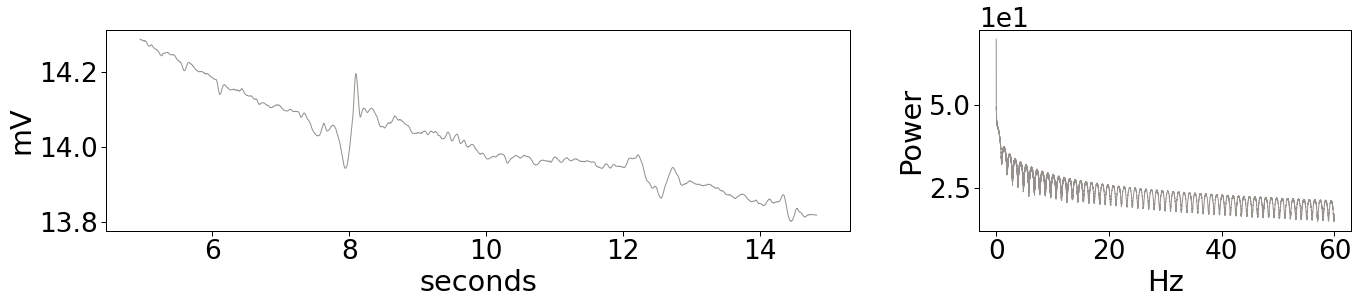

In [55]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:3000], 
             signal.decimate(timeseries['EDA'][:200000], 10)[1000:3000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-eda_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [56]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 5.5885, 1: 5.595258333333334, 2: 5.592233333333334, 3: 5.563108333333333, 4: 5.001758333333333, 5: 5.001774999999999}


In [57]:
scan1 = timeseries[timeseries.index.isin(scan_idx[1])]
time = scan1['seconds'].values

In [58]:
f, Cxy = signal.coherence(scan1['EDA'], 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second)

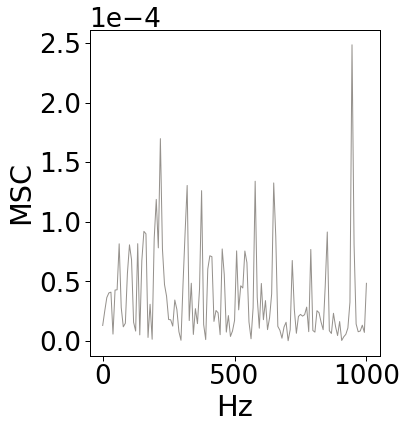

In [59]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaRaw.png'.format(out_dir, basename, i), dpi=300)

In [60]:
fft_eda = np.fft.fft(scan1['EDA'].values)
freq = np.fft.fftfreq(scan1['EDA'].values.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_eda.real[:30000], distance=300)

In [61]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)


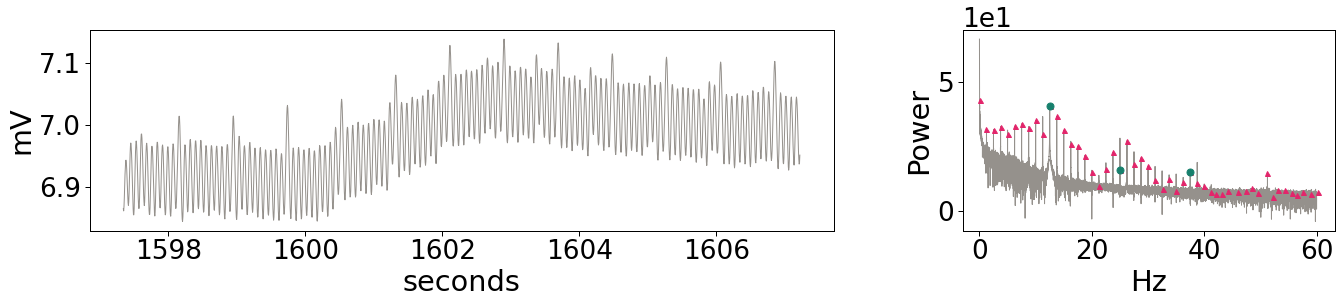

In [62]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(scan1['EDA'], 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_eda_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_eda_db[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:50], fft_eda_db[peaks][:50], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_eda_db[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_eda-raw.png'.format(out_dir, basename, i), dpi=300)

In [63]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / tr
filtered = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

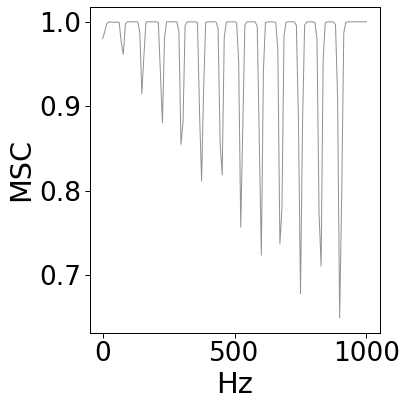

In [64]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

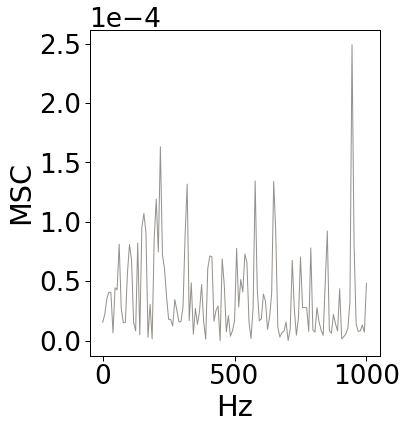

In [65]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], filtered, fs=data.samples_per_second)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

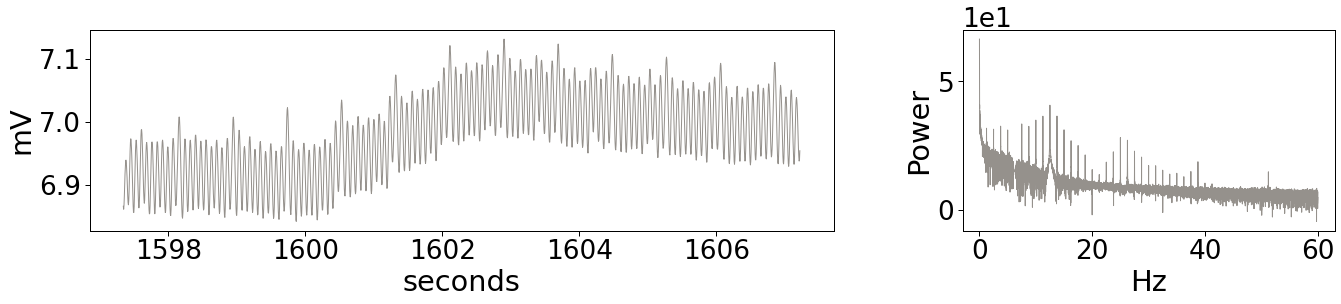

In [66]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-eda_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [67]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / mb / tr
filtered1 = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered1, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

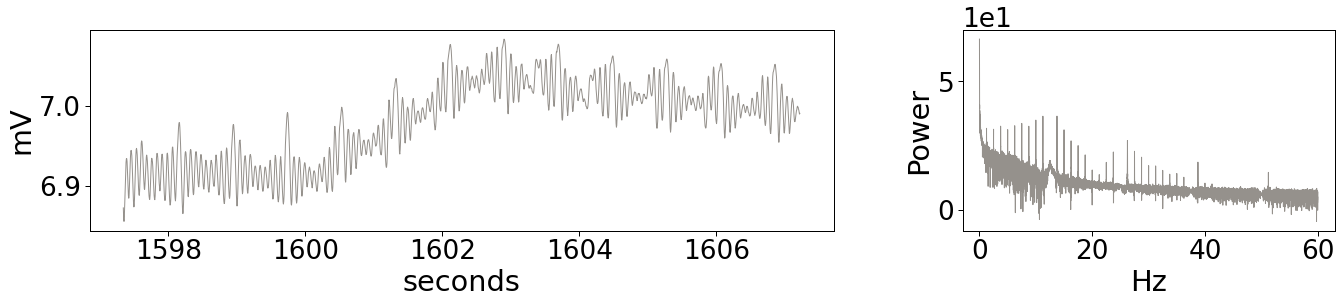

In [68]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered1, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-eda_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

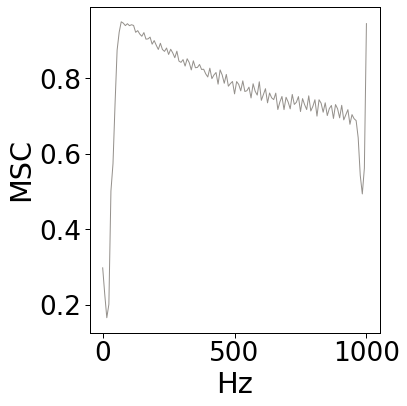

In [69]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

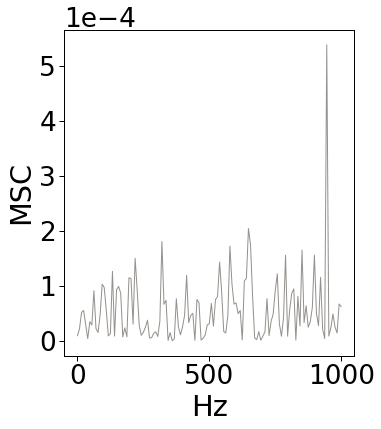

In [70]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], filtered1, fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

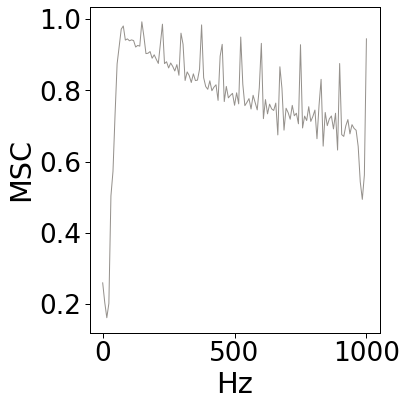

In [71]:
f, Cxy = signal.coherence(filtered, filtered1, fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)

ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

fig.savefig('{0}/figures/{1}-scan{2}-edaBioPacCleanXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

## Multiband, multiecho BOLD EPI sequence

In [72]:
data_fname = '/Users/kbottenh/Dropbox/Projects/physio/mbme-physio-denoising/example_data/sub-Blossom_ses-01.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/kbottenh/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [73]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Trigger' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel


In [74]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [75]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = data.samples_per_second

#I don't know if this is right, been playing around with the value of Q
Q = 100

nyquist = fs/2

In [76]:
fft_eda = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

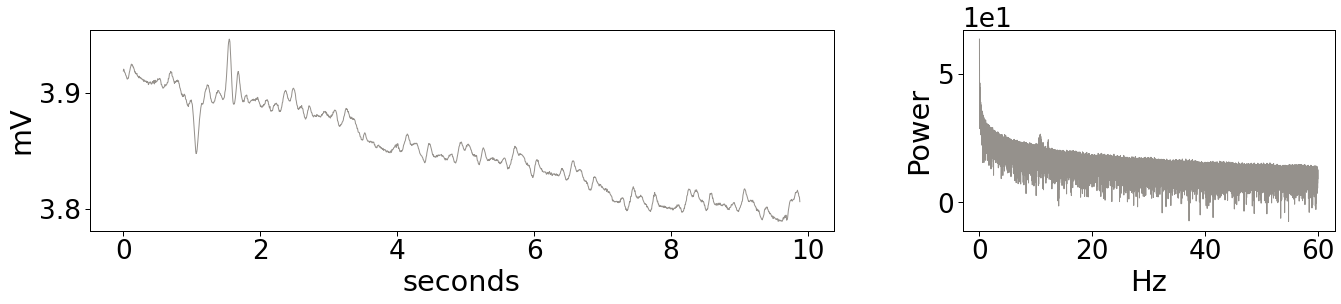

In [77]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[:2000], 
             signal.decimate(timeseries['EDA'][:200000], 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-eda_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [78]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 9.394791666666666, 1: 7.744491666666667, 2: 7.7928, 3: 7.350816666666666, 4: 7.976075, 5: 10.925783333333333, 6: 7.412583333333333, 7: 7.43005, 8: 5.836325, 9: 8.253416666666666, 10: 5.0017249999999995, 11: 5.001608333333333}


In [79]:
scan1 = timeseries[timeseries.index.isin(scan_idx[0])]
time = scan1['seconds'].values

In [80]:
f, Cxy = signal.coherence(scan1['EDA'], 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second)

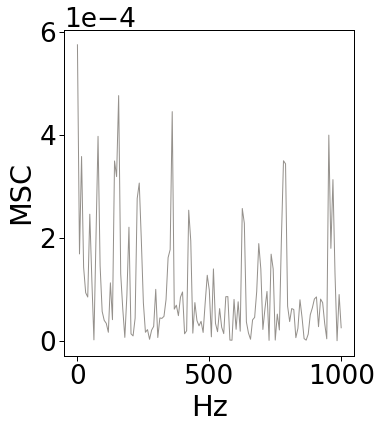

In [81]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaRaw.png'.format(out_dir, basename, i), dpi=300)

In [82]:
fft_eda = np.fft.fft(scan1['EDA'].values)
freq = np.fft.fftfreq(scan1['EDA'].values.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_eda.real[:30000], distance=150)

In [83]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

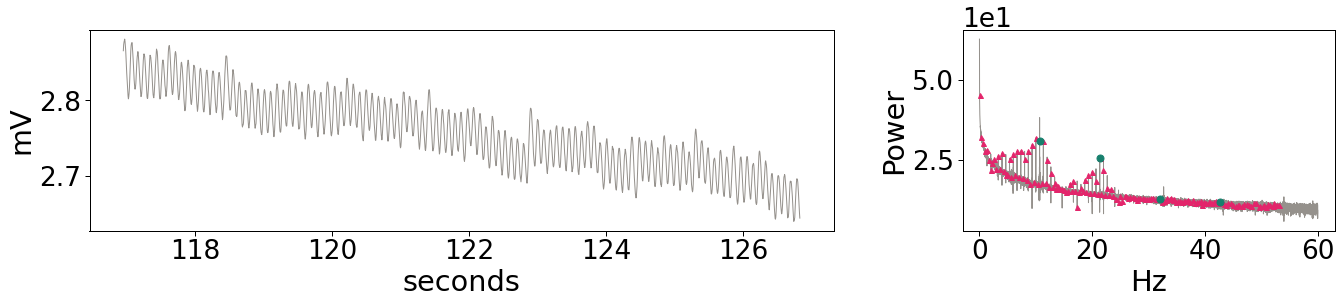

In [84]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(scan1['EDA'], 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_eda_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_eda_db.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:220], fft_eda_db.real[peaks][:220], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_eda_db.real[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_eda-raw.png'.format(out_dir, basename, i), dpi=300)

### BioPac recommendations

In [85]:
notch = slices / tr
filtered = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

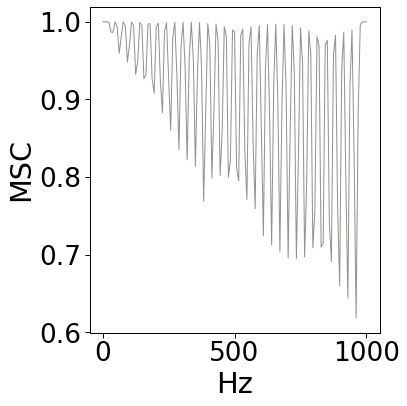

In [86]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

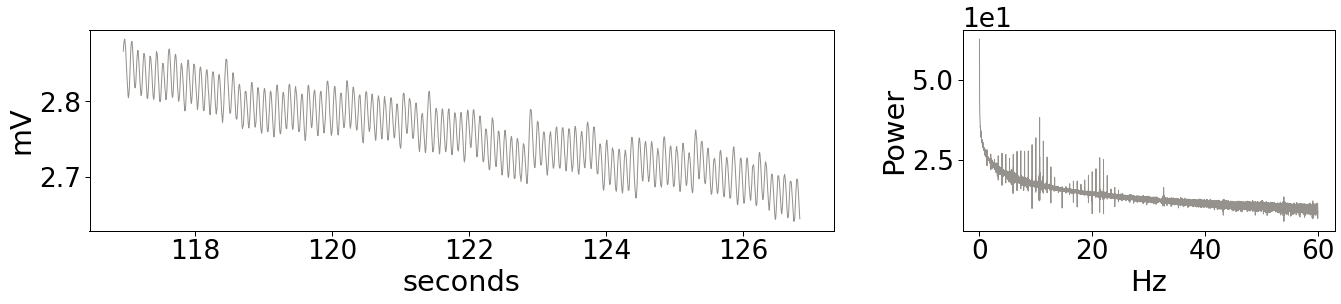

In [87]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_eda_db.real[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-scan{2}-eda_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

### Bottenhorn recommendations

In [88]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}

#hp_eda = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
filtered1 = scan1['EDA']
for notch in notches:
    filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

f, Cxy = signal.coherence(scan1['EDA'], filtered1, fs=data.samples_per_second)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

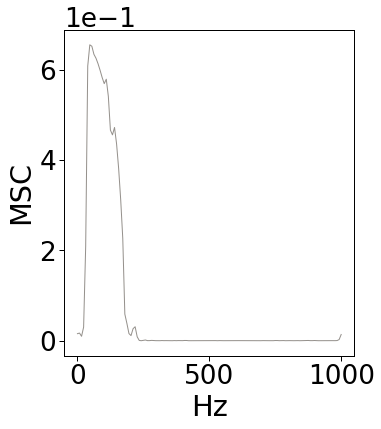

In [89]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

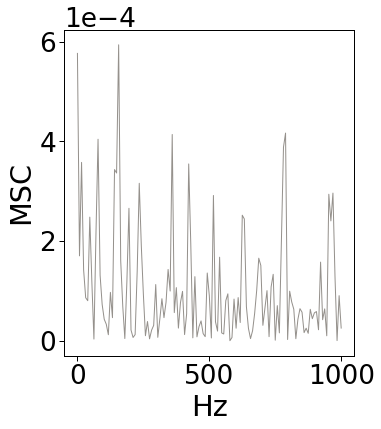

In [90]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          filtered, 
                          fs=data.samples_per_second)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

In [91]:
f, Cxy = signal.coherence(filtered1, 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second)

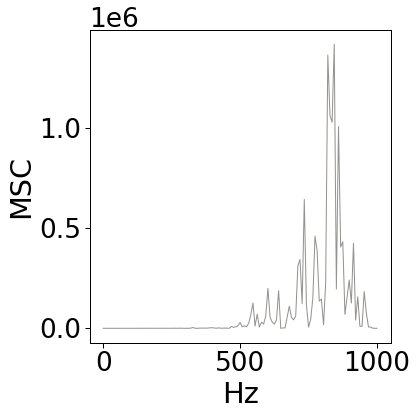

In [92]:
fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(f, Cxy, linewidth=1)
plt.tight_layout()
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [93]:
f, Cxy = signal.coherence(filtered1, 
                          filtered, 
                          fs=data.samples_per_second)

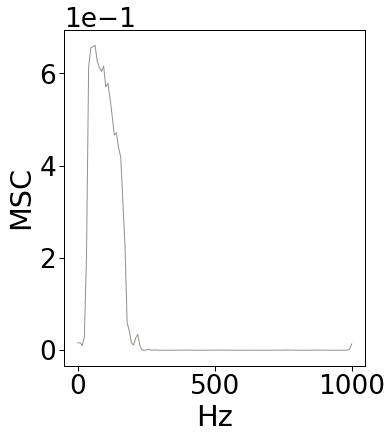

In [94]:
fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(f, Cxy, linewidth=1)
plt.tight_layout()
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaBioPacCleanXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

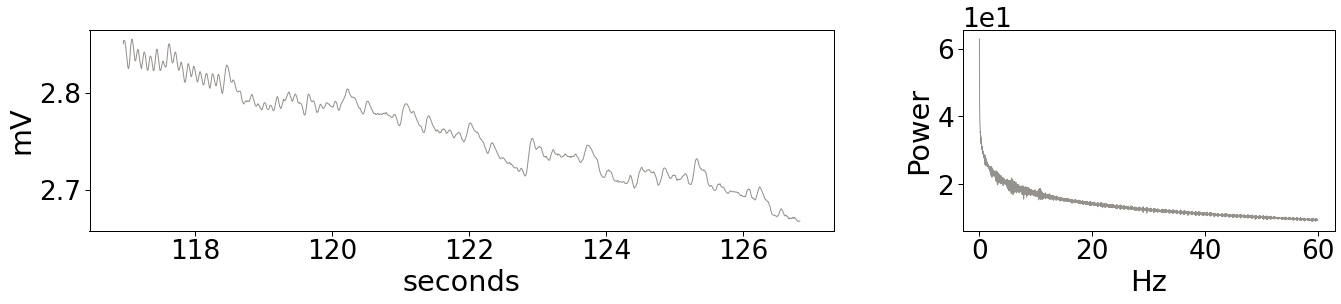

In [95]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:2000], 
            signal.decimate(filtered1, 10)[:2000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_eda_db.real[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-scan{2}-eda_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()